In [524]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

import pytz
import shap
import pickle

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42

# Perameters


In [603]:
node_id = '10004098'
dir_out = '../figures/spatial/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1))#.astype(str)
#for i in range(len(wavelengths)):
#    wavelengths[i] = wavelengths[i] + 'nm'
#wavelengths = list(wavelengths)

# Read Data

In [604]:
# if data has been preprocessed before, run this directly
km_max = 5
fn_data = dir_data + 'driving_' + node_id + '_NEXRAD_'+str(km_max)+'km_landsat_humidity_O3.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')

# iwant = df.index.date < datetime.date(2020, 3, 1)
# df = df[iwant]

surface_reflectances_rename =  {'Surface Reflectance Band 1' : 'Surface Reflectance 435-451 nm', # 435-451nm, Ultra Blue
                                'Surface Reflectance Band 2' : 'Surface Reflectance 452-512 nm', # 452-512nm, Blue
                                'Surface Reflectance Band 3' : 'Surface Reflectance 533-590 nm', # 533-590nm, Greeen
                                'Surface Reflectance Band 4' : 'Surface Reflectance 636-673 nm'} # 636-673nm, Readm

surface_reflectances = ['Surface Reflectance 435-451 nm', # 435-451nm, Ultra Blue
                        'Surface Reflectance 452-512 nm', # 452-512nm, Blue
                        'Surface Reflectance 533-590 nm', # 533-590nm, Greeen
                        'Surface Reflectance 636-673 nm'] # 636-673nm, Red

df = df.rename(columns=surface_reflectances_rename)
df.head()

,Illuminance,360nm,361nm,362nm,363nm,364nm,365nm,366nm,367nm,368nm,...,Reflectivity Level_10km West_5km,Reflectivity Level_10km North_5km West_5km,LocalTime,date,Surface Reflectance 435-451 nm,Surface Reflectance 452-512 nm,Surface Reflectance 533-590 nm,Surface Reflectance 636-673 nm,relativeHumidity,ColumnAmountO3
UTC,,,,,,,,,,,,,,,,,,,,,
2020-01-08 16:43:50,2345.220551,0.032529,0.032651,0.033183,0.033997,0.034946,0.035627,0.036239,0.036761,0.037158,...,NaN,NaN,2020-01-08 10:43:50,2020/01/08,582,656,925,1029,34.780000,286.450012
2020-01-08 16:44:00,2385.540894,0.033112,0.033226,0.033758,0.034580,0.035541,0.036231,0.036851,0.037380,0.037782,...,NaN,NaN,2020-01-08 10:44:00,2020/01/08,974,1096,1371,1635,35.400000,286.450012
2020-01-08 16:46:40,3521.045288,0.036604,0.036802,0.037441,0.038386,0.039475,0.040252,0.040949,0.041550,0.042018,...,NaN,NaN,2020-01-08 10:46:40,2020/01/08,907,1043,1421,1676,34.600000,286.450012
2020-01-08 16:46:50,4220.051209,0.044110,0.044308,0.045068,0.046215,0.047553,0.048541,0.049440,0.050220,0.050827,...,NaN,NaN,2020-01-08 10:46:50,2020/01/08,1042,1167,1566,1761,34.266667,286.450012
2020-01-08 16:47:00,4105.486389,0.043972,0.044196,0.044981,0.046150,0.047503,0.048477,0.049356,0.050115,0.050708,...,NaN,NaN,2020-01-08 10:47:00,2020/01/08,841,925,1185,1359,34.720000,286.450012


In [605]:
len(reflectivities)

451

In [606]:
len(features)

458

In [654]:
df[iwant]

ValueError: Item wrong length 3936 instead of 21508.

In [607]:
len(df)

21508

In [608]:
# grid parameters
step = 100 # grid resolution (meter) in x-y plane

z_0, delta_z = 0, 10000
num_z = int(delta_z // 1000) + 1

delta_y , delta_x  = 1000, 1000 # neighbor distance
delta_iy, delta_ix = int(delta_y / step), int(delta_x / step)

# neighbor parameters
neighbor = {'': (0, 0)}
km_max = 5
for i in range(1,km_max+1): # distance (km)
    neighbor['North_%dkm'          %(i  )] = ( i*delta_iy,           0)
    neighbor['North_%dkm East_%dkm'%(i,i)] = ( i*delta_iy,  i*delta_ix)
    neighbor[           'East_%dkm'%(  i)] = (          0,  i*delta_ix)
    neighbor['South_%dkm East_%dkm'%(i,i)] = (-i*delta_iy,  i*delta_ix)
    neighbor['South_%dkm'          %(i  )] = (-i*delta_iy,           0)
    neighbor['South_%dkm West_%dkm'%(i,i)] = (-i*delta_iy, -i*delta_ix)
    neighbor[           'West_%dkm'%(  i)] = (          0, -i*delta_ix)
    neighbor['North_%dkm West_%dkm'%(i,i)] = ( i*delta_iy, -i*delta_ix)
    

In [609]:
features0 = ['Zenith',  'relativeHumidity', 'ColumnAmountO3']
# features0 = ['altitude', 'Zenith', 'Azimuth',  'relativeHumidity']
# features0 = ['Zenith', 'Sun Distance']

features = features0.copy()
reflectivities = []
for iz in range(num_z):
    for direction in neighbor:
        var = 'Reflectivity Level_%dkm' % (iz)
        if direction:
            var += ' ' + direction
        reflectivities.append(var)

features += reflectivities

features += surface_reflectances
features = np.array(features)

num_features = len(features)
print(num_features)

wavelengths = np.array(range(360,780+1))#.astype(str)
targets =np.array([str(wavelength) + 'nm' for wavelength in wavelengths]) # skip Illuminance, keep Wavelengths
# targets = ['Illuminance']


458


In [610]:
# try to apply exp on the reflectivities
# since L_Z=10 log10(Z/Z_0) in dbz
# so (Z/Z_0) = 10^(L_z/10)
# df[reflectivities] = (10**(df[reflectivities]/10)).fillna(0)

# simply use 0,1 to represent the reflectivities
df[reflectivities] = df[reflectivities].notnull().astype(int)[reflectivities]

In [611]:
# cut off the brightness of night or when the sensor is covered
iwant = (df['Illuminance'] > 1000) #& (df.index.date < datetime.date(2020, 4, 1)) #& (df.index.date < datetime.date(2020, 4, 1))

In [612]:
X = df[features][iwant]
Y = df[targets][iwant] # model and scaler use multi output

In [613]:
# def showCorr(cols):
#     size = len(cols)*0.8
#     fig = plt.figure(figsize=(size, size))
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(df[cols].corr(), cmap='RdBu')
#     cax.set_clim(-1, 1);
#     #plt.title('Correlation Matrix\n\n\n')
#     fig.colorbar(cax)
#     ax.set_xticklabels(np.append([""],cols), rotation=45, ha="left")
#     ax.set_yticklabels(np.append([""],cols))
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#     plt.show()

In [652]:
Y.std()

360nm    0.018147
361nm    0.018827
362nm    0.019755
363nm    0.020849
364nm    0.022020
           ...   
776nm    0.147495
777nm    0.147603
778nm    0.147665
779nm    0.147577
780nm    0.147354
Length: 421, dtype: float64

In [614]:
# showCorr(np.append(features, targets[0]))

In [615]:
X_train_all, X_test, Y_train_all, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_all, Y_train_all, test_size=0.1, random_state=0)

In [660]:
df['Sun Distance'][Y.index].std()

802336271.6780804

In [616]:
# times distance2
Y_train_distance2 = Y_train.copy()
Y_valid_distance2 = Y_valid.copy()
Y_test_distance2 = Y_test.copy()
for target in targets:
    Y_train_distance2[target] *= df['Sun Distance'][Y_train.index]**2
    Y_valid_distance2[target] *= df['Sun Distance'][Y_valid.index]**2
    Y_test_distance2[target] *= df['Sun Distance'][Y_test.index]**2


In [617]:
# scale the output
scaler_y = StandardScaler()
Y_train_distance2_scaled = scaler_y.fit_transform(Y_train_distance2)
Y_valid_distance2_scaled = scaler_y.transform(Y_valid_distance2)
Y_test_distance2_scaled = scaler_y.transform(Y_test_distance2)


In [618]:
# try PCA to the scaled output
n_components = len(targets)

DR = 'PCA'
pca_y = PCA(n_components=n_components, random_state = RANDOM_STATE)

pca_y.fit_transform(Y_train_distance2_scaled)
(np.add.accumulate(pca_y.explained_variance_)/np.sum(pca_y.explained_variance_))[:10]

array([0.98367702, 0.99921939, 0.99967103, 0.99987232, 0.99996666,
       0.99998968, 0.9999935 , 0.9999958 , 0.99999693, 0.99999792])

In [619]:
# PCA to the scaled output
n_components_PCA_Y = 5

DR = 'PCA'
pca_y = PCA(n_components=n_components_PCA_Y, random_state = RANDOM_STATE)

Y_train_distance2_scaled_DR = pca_y.fit_transform(Y_train_distance2_scaled)
Y_valid_distance2_scaled_DR = pca_y.transform(Y_valid_distance2_scaled)
Y_test_distance2_scaled_DR = pca_y.transform(Y_test_distance2_scaled)

Y_train_distance2_scaled_DR = pd.DataFrame(Y_train_distance2_scaled_DR, index = Y_train.index)
Y_valid_distance2_scaled_DR = pd.DataFrame(Y_valid_distance2_scaled_DR, index = Y_valid.index)
Y_test_distance2_scaled_DR = pd.DataFrame(Y_test_distance2_scaled_DR, index = Y_test.index)

print(pca_y.explained_variance_)

[4.14157255e+02 6.54379956e+00 1.90156278e-01 8.47492244e-02
 3.97194190e-02]


In [620]:
# try PCA on the scaled features of reflectivities
n_components_NEXRAD = len(reflectivities)

pca_NEXRAD = PCA(n_components=n_components_NEXRAD, random_state = RANDOM_STATE)
pca_NEXRAD.fit_transform(X_train[reflectivities])

(np.add.accumulate(pca_NEXRAD.explained_variance_)/np.sum(pca_NEXRAD.explained_variance_))[:50]

array([0.45611928, 0.59184396, 0.62539247, 0.64842735, 0.67010166,
       0.69014791, 0.70587139, 0.71864284, 0.72944273, 0.73959443,
       0.74904381, 0.75779287, 0.76596982, 0.77325012, 0.78008189,
       0.78655401, 0.79236124, 0.79758206, 0.80246913, 0.80730092,
       0.81185505, 0.81625071, 0.82040233, 0.82450068, 0.82837887,
       0.83195235, 0.83544382, 0.83876371, 0.84186588, 0.84476636,
       0.84762886, 0.85034231, 0.85297565, 0.85552078, 0.85805715,
       0.86041858, 0.86274593, 0.86501425, 0.86717123, 0.86913163,
       0.8710725 , 0.87297812, 0.87480985, 0.87661727, 0.87833999,
       0.88001994, 0.88166628, 0.88329192, 0.88488235, 0.88644432])

In [621]:
# PCA on the scaled features of reflectivities
n_components_NEXRAD = 32
reflectivities_DR = ['Reflectivity PC ' + str(i) for i in range(n_components_NEXRAD)]

DR = 'PCA'
pca_NEXRAD = PCA(n_components=n_components_NEXRAD, random_state = RANDOM_STATE)

features_DR = features0 + reflectivities_DR + surface_reflectances
num_features_DR = len(features_DR)

X_train_DR = X_train[features0].copy()
X_train_DR[reflectivities_DR] = pca_NEXRAD.fit_transform(X_train[reflectivities])
X_train_DR[surface_reflectances] = X_train[surface_reflectances]

X_valid_DR = X_valid[features0].copy()
X_valid_DR[reflectivities_DR] = pca_NEXRAD.transform(X_valid[reflectivities])
X_valid_DR[surface_reflectances] = X_valid[surface_reflectances]

X_test_DR = X_test[features0].copy()
X_test_DR[reflectivities_DR] = pca_NEXRAD.transform(X_test[reflectivities])
X_test_DR[surface_reflectances] = X_test[surface_reflectances]

print(pca_NEXRAD.explained_variance_)

[36.16893711 10.76257344  2.66030015  1.82659929  1.71870952  1.58961001
  1.24682629  1.01273892  0.85640001  0.80500051  0.74930833  0.69377493
  0.64840866  0.57730675  0.54173968  0.51322     0.46049679  0.41399478
  0.38753052  0.38314705  0.36112924  0.34856194  0.32920731  0.32495275
  0.30750931  0.28332798  0.27677322  0.26318948  0.24575671  0.22986032
  0.22678733  0.2150424 ]


# Model Trainning

In [622]:
import lightgbm as lgb
from xgboost.sklearn import XGBRegressor
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
DR = 'PCA'

In [417]:
best_params = {}
best_score = {}

for i in range(n_components_PCA_Y):
    # RandomizedSearchCV
    rs_params = {
    #     'boosting_type': ['gbdt'], # default = 'gbdt'
        'num_leaves': range(2, 200), # default = 31, Maximum tree leaves for base learners
        'max_depth' : list(range(1,20)) + [-1], # default = -1, Maximum tree depth for base learners
        'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4], # default = 0.1
        'n_estimators': range(10, 200, 10), # default = 100, Number of boosted trees
    #     'subsample_for_bin': [200000], # default = 200000
        'objective' : ['regression'], # ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
    #     'class_weight': ['balanced'], # default = None, for multi-class
    #     'is_unbalance': [True], # default = False, for binary
    #     'min_split_gain' : [0.], # default=0.
    #     'min_child_weight' : [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], # default=1e-3
    #     'min_child_samples': range(1, 500), # default=20
        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # default=1.
    #     'subsample_freq': [0], # default=0
        'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # default=1.
        'reg_alpha': [0, 1e-1, 0.5, 1, 2, 5, 7, 10, 50, 100], # default=0.  L1 regularization
        'reg_lambda': [0, 1e-1, 0.5, 1, 5, 10, 20, 50, 100], # default=0.  L2 regularization
        'random_state' : [RANDOM_STATE], # default=None
    #     'n_jobs': [-1], # default=-1
        'silent': [True], # default=True
    #     'importance_type': ['split'], # default='split', or 'gain'
    }

    start_time = time.time()
    rs_cv = RandomizedSearchCV(estimator = lgb.LGBMRegressor(random_state = RANDOM_STATE), 
                               param_distributions = rs_params,
    #                            scoring= '',
                               refit = True,
                               verbose = True,
                               cv = 2,
                               n_jobs = -1,
                               n_iter = 5000,
                              )
    fit_params = {"early_stopping_rounds":30, 
                  "eval_metric" : 'mse', #
                  "eval_set" : [(X_valid, Y_valid_distance2_scaled_DR.values[:,4])],
                  'eval_names': ['valid'],
                  'verbose': 0,
                  'categorical_feature': 'auto'
                 }

    # Train on training data
    warnings.filterwarnings("ignore")
    # rs_cv.fit(X_train_scaled_DR_scaled, Y_train_scaled, **fit_params)
    rs_cv.fit(X_train, Y_train_distance2_scaled_DR.values[:,4], **fit_params)

    print(rs_cv.best_params_)
    print(rs_cv.best_score_)
    
    best_params[str(i)] = rs_cv.best_params_
    best_score[str(i)] = rs_cv.best_score_

    print("--- %s seconds ---" % (time.time() - start_time))

Fitting 2 folds for each of 5000 candidates, totalling 10000 fits
{'subsample': 0.8, 'silent': True, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 42, 'objective': 'regression', 'num_leaves': 123, 'n_estimators': 140, 'max_depth': 15, 'learning_rate': 0.08, 'colsample_bytree': 0.9}
0.9615433007363461
--- 3613.5419108867645 seconds ---
Fitting 2 folds for each of 5000 candidates, totalling 10000 fits
{'subsample': 0.2, 'silent': True, 'reg_lambda': 0.5, 'reg_alpha': 0, 'random_state': 42, 'objective': 'regression', 'num_leaves': 146, 'n_estimators': 170, 'max_depth': 17, 'learning_rate': 0.08, 'colsample_bytree': 0.9}
0.9622410702976896
--- 3405.498133659363 seconds ---
Fitting 2 folds for each of 5000 candidates, totalling 10000 fits
{'subsample': 0.4, 'silent': True, 'reg_lambda': 20, 'reg_alpha': 0, 'random_state': 42, 'objective': 'regression', 'num_leaves': 101, 'n_estimators': 170, 'max_depth': 17, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
0.9614655133175581
--- 3351.91471

In [418]:
best_params

{'0': {'subsample': 0.8,
  'silent': True,
  'reg_lambda': 0,
  'reg_alpha': 0,
  'random_state': 42,
  'objective': 'regression',
  'num_leaves': 123,
  'n_estimators': 140,
  'max_depth': 15,
  'learning_rate': 0.08,
  'colsample_bytree': 0.9},
 '1': {'subsample': 0.2,
  'silent': True,
  'reg_lambda': 0.5,
  'reg_alpha': 0,
  'random_state': 42,
  'objective': 'regression',
  'num_leaves': 146,
  'n_estimators': 170,
  'max_depth': 17,
  'learning_rate': 0.08,
  'colsample_bytree': 0.9},
 '2': {'subsample': 0.4,
  'silent': True,
  'reg_lambda': 20,
  'reg_alpha': 0,
  'random_state': 42,
  'objective': 'regression',
  'num_leaves': 101,
  'n_estimators': 170,
  'max_depth': 17,
  'learning_rate': 0.2,
  'colsample_bytree': 1.0},
 '3': {'subsample': 0.6,
  'silent': True,
  'reg_lambda': 0,
  'reg_alpha': 0,
  'random_state': 42,
  'objective': 'regression',
  'num_leaves': 148,
  'n_estimators': 180,
  'max_depth': -1,
  'learning_rate': 0.08,
  'colsample_bytree': 0.7},
 '4': {'su

In [ ]:
rs_cv.best_params_

In [373]:
# param = {
# 'subsample': 0.8, #
# 'verbosity': 0, # 0 (silent) - 3 (debug)
# 'reg_lambda': 50, #
# 'reg_alpha': 0, #
# 'random_state': 42, #
# 'objective': 'reg:squarederror', #
# # 'num_leaves': 153, 
# 'n_estimators': 140, #
# 'max_depth': 9, #
# 'learning_rate': 0.1, #
# 'colsample_bytree': 1.0 #
# }

# # structure   = '_' + DR + str(n_components) \
# # structure   = '_' + 'ne' + str(param['n_estimators'])\
# #             + '_' + 'de' + str(param['max_depth'])\
# #             + '_' + 'sr' + str(param['subsample'])\
# #             + '_' + 'fr' + str(param['colsample_bytree'])\
# #             + '_' + 'l1_' + str(param['reg_alpha'])\
# #             + '_' + 'l2_' + str(param['reg_lambda'])\

# model_base = XGBRegressor(**param)
# num_labels = n_components_PCA_Y
# model = MultiOutputModel(model_base, num_labels)
# fit_params = {"early_stopping_rounds":30,
#               "eval_metric": 'rmse', # l2 is mean_squared_error
#               "eval_set": [(X_valid_DR, Y_valid_distance2_scaled_DR)],
# #               'eval_names': ['valid'],
#               'verbose': 0, # bool
#              }

# warnings.filterwarnings("ignore")
# start_time = time.time()
# model.fit(X_train_DR, Y_train_distance2_scaled_DR, **fit_params)
# print("--- %s seconds ---" % (time.time() - start_time))

In [623]:
class MultiOutputModel:
    def __init__(self, estimator, num_labels, **params):
        import copy
        self.num_labels = num_labels
        self.estimators_ = []
        for i in range(num_labels):
            self.estimators_.append(estimator(**params[str(i)]))
    
    def fit(self, X_fit, Y_fit, **fit_params):
        X_eval, Y_eval = fit_params['eval_set'][0]
        Y_eval = np.array(Y_eval)
        for i in range(self.num_labels):
            fit_params_i = fit_params.copy()
            fit_params_i['eval_set'] = [( X_eval, Y_eval[:,i] )]
            self.estimators_[i].fit(X_fit, Y_fit.values[:,i], **fit_params_i)
    
    def predict(self, X_calculate):
        result = np.zeros([X_calculate.shape[0], self.num_labels])
        for i in range(self.num_labels):
            result[:,i] = self.estimators_[i].predict(X_calculate)
        
        return result

In [568]:
len(df)

21508

In [624]:
# Fit the Model with Optimized Hyper-Parameters
# param = {
#     'num_leaves': 128, # default = 31, Maximum tree leaves for base learners
#     'max_depth' : -1, # default = -1, Maximum tree depth for base learners
#     'learning_rate': 0.05, # default = 0.1
#     'n_estimators': 140, # default = 100, Number of boosted trees
# #     'subsample_for_bin': 200000, # default = 200000
#     'objective' : 'regression', # ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
# #     'class_weight': 'balanced', # default = None, for multi-class
# #     'min_child_weight' : 100., # default=1e-3
# #     'min_child_samples': 467, # default=20
#     'subsample': 1.0, # default=1.
#     'colsample_bytree': 0.9, # default=1.
#     'reg_alpha': 50, # default=0.  L1 regularization
#     'reg_lambda': 0, # default=0.  L2 regularization
#     'random_state' : RANDOM_STATE, # default=None
#     'silent': True, # default=True
# }

# param = {
# 'subsample': 0.8,
# 'silent': True,
# 'reg_lambda': 50,
# 'reg_alpha': 0,
# 'random_state': 42,
# 'objective': 'regression',
# 'num_leaves': 153,
# 'n_estimators': 140,
# 'max_depth': 12, #-1,
# 'learning_rate': 0.1,
# 'colsample_bytree': 1.0
# }

params = {}

# 0, 0.98
params['0'] = {
'subsample': 0.8,
'silent': True,
'reg_lambda': 100,
'reg_alpha': 7,
'random_state': 42,
'objective': 'regression',
'num_leaves': 192,
'n_estimators': 120,
'max_depth': 13,
'learning_rate': 0.3,
'colsample_bytree': 1.0
}

# 1, 0.98
params['1'] = {
'subsample': 0.9,
'silent': True,
'reg_lambda': 0.1,
'reg_alpha': 1,
'random_state': 42,
'objective': 'regression',
'num_leaves': 169,
'n_estimators': 170,
'max_depth': 10,
'learning_rate': 0.1,
'colsample_bytree': 0.8
}

# 2, 0.9825
params['2'] = {
'subsample': 0.2,#0.2,
'silent': True,
'reg_lambda': 5,
'reg_alpha': 0.1,
'random_state': 42,
'objective': 'regression',
'num_leaves': 140,
'n_estimators': 170,
'max_depth': 14,
'learning_rate': 0.08,
'colsample_bytree': 0.9
}

# 3, 0.9805
params['3'] = {
'subsample': 0.9,
'silent': True,
'reg_lambda': 5,
'reg_alpha': 0,
'random_state': 42,
'objective': 'regression',
'num_leaves': 136,
'n_estimators': 170,
'max_depth': 17,
'learning_rate': 0.1,
'colsample_bytree': 0.7
}

# 4, 0.9792
params['4'] = {
'subsample': 0.4,
'silent': True,
'reg_lambda': 1,
'reg_alpha': 0,
'random_state': 42,
'objective': 'regression',
'num_leaves': 141,
'n_estimators': 180,
'max_depth': 17,
'learning_rate': 0.08,
'colsample_bytree': 0.7
}

for i in range(n_components_PCA_Y):
    params[str(i)] = params['2']
    
# structure   = '_' + DR + str(n_components) \
structure   = '_' + 'ne' + str(param['n_estimators'])\
            + '_' + 'de' + str(param['max_depth'])\
            + '_' + 'nl' + str(param['num_leaves'])\
            + '_' + 'sr' + str(param['subsample'])\
            + '_' + 'fr' + str(param['colsample_bytree'])\
            + '_' + 'l1_' + str(param['reg_alpha'])\
            + '_' + 'l2_' + str(param['reg_lambda'])\

model_base = lgb.LGBMRegressor#(**param)
num_labels = n_components_PCA_Y
model = MultiOutputModel(model_base, num_labels, **params)

fit_params = {"early_stopping_rounds":30, 
              "eval_metric": 'mse', # l2 is mean_squared_error
              "eval_set": [(X_valid_DR, Y_valid_distance2_scaled_DR)],
              'eval_names': ['valid'],
              'verbose': 0, # int
              'categorical_feature': 'auto', # default='auto'
             }


warnings.filterwarnings("ignore")
start_time = time.time()
model.fit(X_train_DR, Y_train_distance2_scaled_DR, **fit_params)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.819220066070557 seconds ---


In [570]:
model.estimators_[0].best_iteration_

110

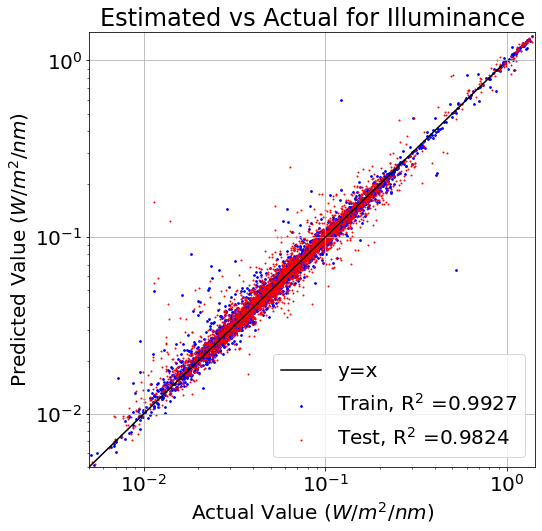

In [625]:
from sklearn.metrics import r2_score

# train
Y_train_pred = scaler_y.inverse_transform(pca_y.inverse_transform(model.predict(X_train_DR)))#[reflectivities_DR] )
# test
Y_test_pred = scaler_y.inverse_transform(pca_y.inverse_transform(model.predict(X_test_DR)))#[reflectivities_DR] )

for i, target in enumerate(targets):
    Y_train_pred[:,i] /= df['Sun Distance'][Y_train.index]**2
    Y_test_pred[:,i] /= df['Sun Distance'][Y_test.index]**2

train_score = r2_score(Y_train, Y_train_pred)
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 3000, replace = False)
plt.scatter(Y_train_flatten[id_train], Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])

id_test = np.random.choice(len(Y_test_flatten), 3000, replace = False)
plt.scatter(Y_test_flatten[id_test], Y_test_pred_flatten[id_test], s=1, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])

plt.xlim(5E-3, )
plt.ylim(5E-3, )

ax.set_title('Estimated vs Actual for Illuminance')# Spectrum')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Predicted Value $(W/m^2/nm)$')
plt.xscale('log')
plt.yscale('log')
plt.legend( loc='lower right')
plt.grid()
# plt.tight_layout()

if not os.path.exists(dir_out + 'whole'):
    os.mkdir(dir_out + 'whole')
plt.savefig(dir_out + 'whole' +'/Lightgbm_performance_whole'+structure+'.png')



In [626]:
Y_train_flatten_sorted = np.sort(Y_train_flatten)
Y_train_pred_flatten_sorted = np.sort(Y_train_pred_flatten)

Y_test_flatten_sorted = np.sort(Y_test_flatten)
Y_test_pred_flatten_sorted = np.sort(Y_test_pred_flatten)

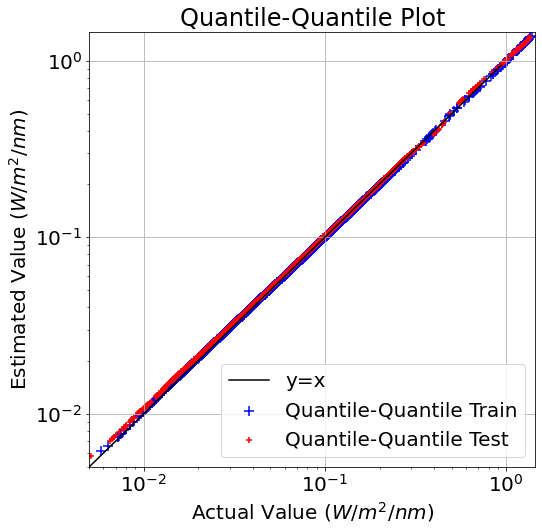

In [627]:
Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)
y_line = np.linspace(Y_min,Y_max,100)
# 

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten_sorted), 2000, replace = False)
plt.scatter(Y_train_flatten_sorted[id_train], Y_train_pred_flatten_sorted[id_train], s=100, c = 'blue',
            marker = '+', label = 'Quantile-Quantile Train')

id_test = np.random.choice(len(Y_test_flatten_sorted), 2000, replace = False)
plt.scatter(Y_test_flatten_sorted[id_test], Y_test_pred_flatten_sorted[id_test], s=30, c = 'red',
            marker = '+', label = 'Quantile-Quantile Test')
plt.xlim(5E-3, )
plt.ylim(5E-3, )

# x_25 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4]
# y_25 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4]
# x_50 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//2]
# y_50 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//2]
# x_75 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4*3]
# y_75 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4*3]
# plt.text(x_25, y_25, '25', c ='blue', ha = 'center', va = 'center')
# plt.text(x_50, y_50, '50', c ='blue', ha = 'center', va = 'center')
# plt.text(x_75, y_75, '75', c ='blue', ha = 'center', va = 'center')

ax.set_title('Quantile-Quantile Plot')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Estimated Value $(W/m^2/nm)$')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend( loc='lower right')

# plt.tight_layout()

if not os.path.exists(dir_out + 'whole'):
    os.mkdir(dir_out + 'whole')
plt.savefig(dir_out + 'whole' +'/Lightgbm_QQ_whole'+structure+'.png')


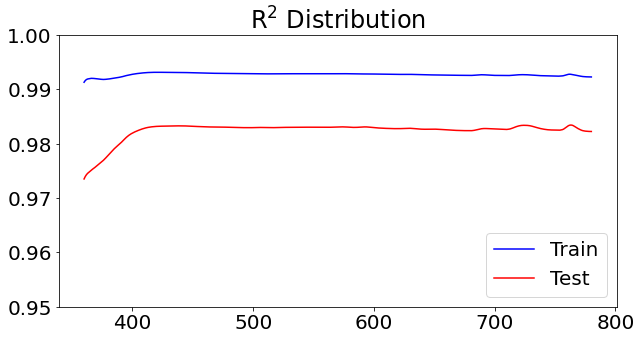

In [628]:
train_scores = []
test_scores = []
for i in range(len(wavelengths)):
    train_scores.append( r2_score(Y_train.iloc[:,i], Y_train_pred[:,i]) )
    test_scores.append( r2_score(Y_test.iloc[:,i], Y_test_pred[:,i]) )

plt.rcParams["figure.figsize"] = (10, 5) # (w, h)
plt.plot(np.array(range(360,780+1)),train_scores, 'b', label = 'Train')
plt.plot(np.array(range(360,780+1)),test_scores, 'r', label = 'Test')
plt.ylim(0.95,1)
plt.title("R$^2$ Distribution")
plt.legend( loc='lower right')
plt.savefig(dir_out + 'whole' + '/Lightgbm_R2' + structure + '.png')

In [548]:
# Create object that can calculate shap values
num_shap = 1000
start_time = time.time()

# num_shap x num_features_DR x n_components_PCA_Y
tree_shap_values_multi_Yscaled_DR = np.zeros((num_shap, num_features_DR, n_components_PCA_Y))

for i in range(n_components_PCA_Y):
    explainer_i = shap.TreeExplainer(model.estimators_[i])
    # num_shap x num_features_DR
    tree_shap_values_multi_Yscaled_DR[:,:,i] = explainer_i.shap_values(X_train_DR[:num_shap])

print("--- %s seconds ---" % (time.time() - start_time))

--- 18.835637092590332 seconds ---


In [549]:
# num_shap x num_features_DR x num_targets
tree_shap_values_multi_Yscaled = np.matmul(tree_shap_values_multi_Yscaled_DR, pca_y.components_)

# scaled SHAP values averaged on different wavelengths
# num_shap x num_features_DR
tree_shap_values_Yscaled = np.mean(tree_shap_values_multi_Yscaled, axis = -1)

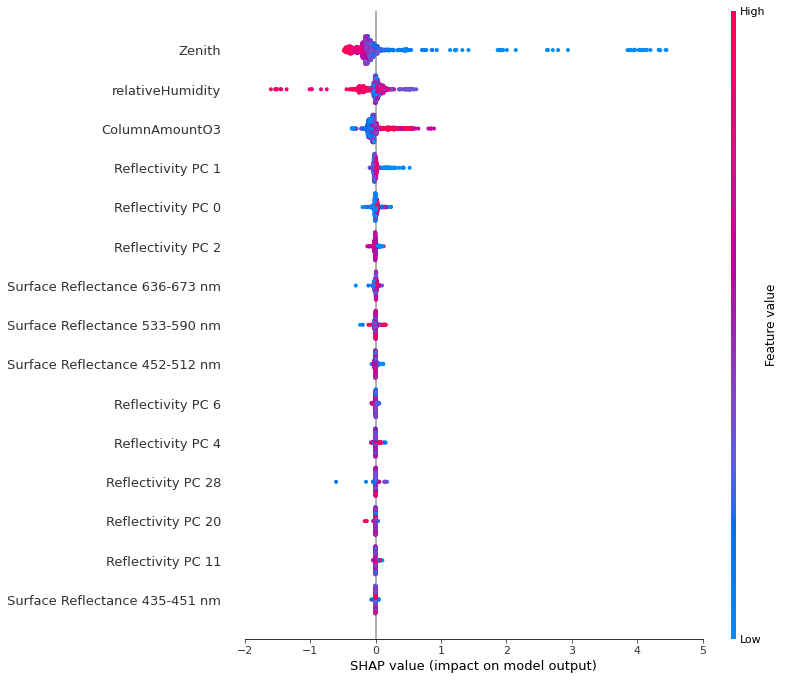

In [573]:
# plot
max_display = 15

shap.summary_plot(tree_shap_values_Yscaled, X_train_DR[:num_shap],
#                   feature_names = features_DR,
                  plot_size=(12,int(max_display/1.5)),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.xlim(-2, 5)
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/Lightgbm_shap_'+ 'whole' +structure+'.png')

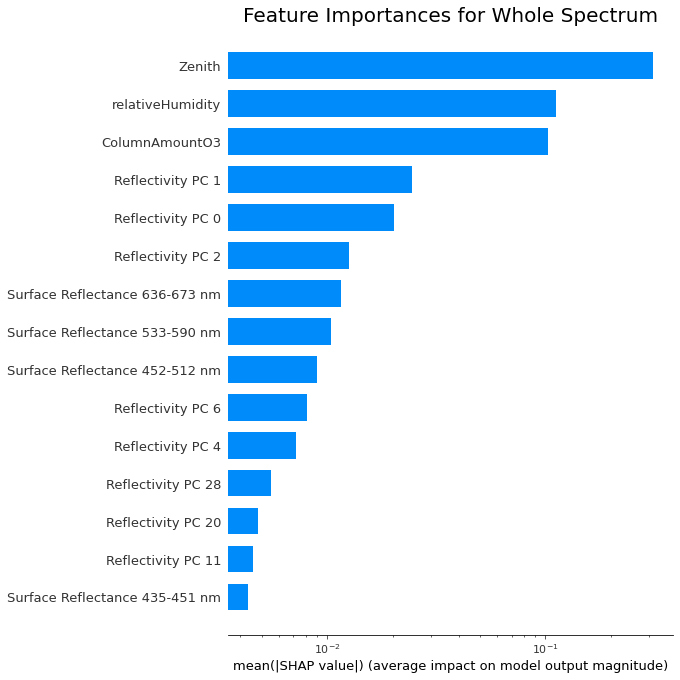

In [574]:
importances = np.mean(np.abs(tree_shap_values_Yscaled), axis = 0)
indices = np.argsort(importances)

# color positive/negative impact blue/red
# colormap = {1:'red',-1:'blue', 0:'grey'}
# impacts = np.array([])
# corrcoef = np.array([])
# sign = np.array([])
# for i in range(n_components):
#     impact_i = (shap_values_DR[:,i]*np.sign(X_train_scaled_DR_scaled[:num_shap,i] - X_train_scaled_DR_scaled[:num_shap, i].mean() )).mean()
#     impacts = np.append(impacts, impact_i)

#     corrcoef_i = np.corrcoef(X_train_scaled_DR_scaled[:,i], Y_train_pred.mean(axis = 1))[0,1]
#     corrcoef = np.append(corrcoef, corrcoef_i)
    
#     sign_i = np.sign(corrcoef_i)
#     sign = np.append(sign, sign_i)

# sign = sign[indices]
# impacts = impacts[indices]
# corrcoef = corrcoef[indices]

# # norm = mpl.colors.SymLogNorm(10, vmin=0, vmax=+0.05)
# norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
# cmap = cm.get_cmap('RdBu_r')
# m = cm.ScalarMappable(norm=norm, cmap=cmap)

# color = [colormap[val] for val in sign]
# # color = [m.to_rgba(val) for val in impacts]
# # color = [m.to_rgba(val) for val in corrcoef]

shap.summary_plot(tree_shap_values_Yscaled, X_train_DR[:num_shap],
                  feature_names = features_DR,
                  plot_size=(10,int(max_display/1.5)),#'auto'
#                   color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                 )

plt.xscale("log")
plt.title('Feature Importances for Whole Spectrum', fontsize = 20)
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/Lightgbm_'+'Importances_' + 'whole' + structure +'.png')


2020-02-10 20:20:00


## Compare Actual Spectrum and Estimated Spectrum


In [675]:
X_test[X_test.index.date == datetime.date(2020, 2, 10)][:5]

,Zenith,relativeHumidity,ColumnAmountO3,Reflectivity Level_0km,Reflectivity Level_0km North_1km,Reflectivity Level_0km North_1km East_1km,Reflectivity Level_0km East_1km,Reflectivity Level_0km South_1km East_1km,Reflectivity Level_0km South_1km,Reflectivity Level_0km South_1km West_1km,...,Reflectivity Level_10km East_5km,Reflectivity Level_10km South_5km East_5km,Reflectivity Level_10km South_5km,Reflectivity Level_10km South_5km West_5km,Reflectivity Level_10km West_5km,Reflectivity Level_10km North_5km West_5km,Surface Reflectance 435-451 nm,Surface Reflectance 452-512 nm,Surface Reflectance 533-590 nm,Surface Reflectance 636-673 nm
UTC,,,,,,,,,,,,,,,,,,,,,
2020-02-10 17:11:40,51.992359,67.66,272.25,0,0,1,0,0,0,0,...,0,0,0,0,0,0,814,990,1447,1658
2020-02-10 17:20:50,51.118978,67.08,272.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,778,919,1355,1658
2020-02-10 19:25:10,48.521841,64.00,272.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,966,1170,1607,1749
2020-02-10 17:07:10,52.451400,68.78,272.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,756,874,1148,1288
2020-02-10 20:21:20,53.014617,69.74,272.25,1,0,0,0,0,1,1,...,0,0,0,0,0,0,985,1110,1453,1620


In [630]:
from wavelength_to_rgb import wavelength_to_rgb
clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

In [794]:
year1 = 2020
month1 = 2
day1 = 1
hour1 = 20
minute1 = 52
second1 = 50
lag = 6
date_string1 = '%04d-%02d-%02d %02d:%02d:%02d' % (year1, month1, day1, hour1, minute1, second1)
print(date_string1)

wavelengths = np.array(range(360,780+1))

iwant = (X_test_DR.index == date_string1)
X1 = X_test_DR[iwant]
Y1 = Y_test[iwant].values
# Y1 = pca_y.inverse_transform(pca_y.transform(Y1))

Y1_pred = scaler_y.inverse_transform(pca_y.inverse_transform(model.predict(X1)))
for i, target in enumerate(targets):
    Y1_pred[:,i] /= df['Sun Distance'][X1.index]**2

# Y1_pred = scaler_y.inverse_transform(pca_y.inverse_transform(pca_y.transform(scaler_y.transform(Y1))))


2020-02-01 20:52:50


In [795]:
df[df.index == X1.index[0]][['latitude', 'longitude']]

,latitude,longitude
UTC,,
2020-02-01 20:52:50,33.026093,-96.832813


In [788]:
year2 = 2020
month2 = 2
day2 = 10
hour2 = 17
minute2 = 20
second2 = 50
lag = 6
date_string2 = '%04d-%02d-%02d %02d:%02d:%02d' % (year2, month2, day2, hour2, minute2, second2)
print(date_string2)

wavelengths = np.array(range(360,780+1))

iwant = (X_test_DR.index== date_string2)
X2 = X_test_DR[iwant]
Y2 = Y_test[iwant].values
# Y2 = pca_y.inverse_transform(pca_y.transform(Y2))

Y2_pred = scaler_y.inverse_transform(pca_y.inverse_transform(model.predict(X2)))
for i, target in enumerate(targets):
    Y2_pred[:,i] /= df['Sun Distance'][X2.index]**2

# Y2_pred = scaler_y.inverse_transform(pca_y.inverse_transform(pca_y.transform(scaler_y.transform(Y2))))
df[df.index == X2.index[0]][['latitude', 'longitude','Zenith']]

2020-02-10 17:20:50


,latitude,longitude,Zenith
UTC,,,
2020-02-10 17:20:50,33.048915,-96.67352,51.118978


In [780]:
X_test[X_test.index.date == datetime.date(2020, 2, 1)][:50]

,Zenith,relativeHumidity,ColumnAmountO3,Reflectivity Level_0km,Reflectivity Level_0km North_1km,Reflectivity Level_0km North_1km East_1km,Reflectivity Level_0km East_1km,Reflectivity Level_0km South_1km East_1km,Reflectivity Level_0km South_1km,Reflectivity Level_0km South_1km West_1km,...,Reflectivity Level_10km East_5km,Reflectivity Level_10km South_5km East_5km,Reflectivity Level_10km South_5km,Reflectivity Level_10km South_5km West_5km,Reflectivity Level_10km West_5km,Reflectivity Level_10km North_5km West_5km,Surface Reflectance 435-451 nm,Surface Reflectance 452-512 nm,Surface Reflectance 533-590 nm,Surface Reflectance 636-673 nm
UTC,,,,,,,,,,,,,,,,,,,,,
2020-02-01 21:08:10,61.220855,28.240000,307.087494,0,0,0,0,0,0,0,...,0,0,0,0,0,0,886,1003,1325,1492
2020-02-01 20:39:10,57.512856,26.620000,307.087494,1,1,1,1,1,1,1,...,0,0,0,0,0,0,861,1049,1434,1745
2020-02-01 20:40:20,57.649908,27.200000,307.087494,1,1,1,1,1,1,1,...,0,0,0,0,0,0,861,1049,1434,1745
2020-02-01 20:25:10,55.949726,30.360000,307.087494,1,1,1,1,1,1,1,...,0,0,0,0,0,0,861,1049,1434,1745
2020-02-01 20:21:30,55.566210,31.040000,307.087494,1,1,1,1,1,1,1,...,0,0,0,0,0,0,861,1049,1434,1745
2020-02-01 20:17:50,55.192961,29.666667,307.087494,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1088,1160,1422,1607
2020-02-01 20:20:10,55.429513,29.940000,307.087494,1,1,1,1,1,1,1,...,0,0,0,0,0,0,861,1049,1434,1745
2020-02-01 20:30:50,56.563898,29.560000,307.087494,1,1,1,1,0,1,1,...,0,0,0,0,0,0,861,1049,1434,1745
2020-02-01 20:54:50,59.434884,28.916667,307.087494,1,1,1,1,0,1,1,...,0,0,0,0,0,0,909,1057,1324,1515


In [789]:
# actual
date_string = date_string1
spectrum = Y1[0]
Y_max = Y1[0].max()

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')

ax.set_title('Actual Spectrum: '+ date_string.replace('-','/'))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

fig.savefig(dir_out+ 'whole' + '/Spectrum_Street_' + date_string.replace('-','_').replace(' ','_').replace(':','_')+'.png')
plt.close()

In [790]:
# estimate
date_string = date_string1
spectrum = Y1_pred[0]
Y_max = Y1[0].max()

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')
ax.set_title('Estimated Spectrum: '+ date_string.replace('-','/'))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

fig.savefig(dir_out+'whole'+'/Spectrum_Street_' + date_string.replace('-','_').replace(' ','_').replace(':','_')+'_pred.png')
plt.close()

In [791]:
# actual
date_string = date_string2
spectrum = Y2[0]
Y_max = Y2[0].max()

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')

ax.set_title('Actual Spectrum: '+ date_string.replace('-','/'))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

fig.savefig(dir_out+'whole'+'/Spectrum_Street_' + date_string.replace('-','_').replace(' ','_').replace(':','_')+'.png')
plt.close()

In [792]:
# estimate
date_string = date_string2
spectrum = Y2_pred[0]
Y_max = Y2[0].max()

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')
ax.set_title('Estimated Spectrum: '+ date_string.replace('-','/'))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

fig.savefig(dir_out+'whole'+'/Spectrum_Street_' + date_string.replace('-','_').replace(' ','_').replace(':','_')+'_pred.png')
plt.close()

In [793]:
# compare
Y_max = max(Y1[0].max(), Y2[0].max())

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 10))
plt.rcParams.update({'font.size': 25})

## color
spectrum = Y2[0]
y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')


## compare
plt.plot(wavelengths, Y2[0], '-', color = 'gray', linewidth = 3, label = 'Cloudy Actual ' + date_string2.replace('-','/'))
plt.plot(wavelengths, Y2_pred[0], '--', color = 'gray', linewidth = 6, label = 'Cloudy Estimated ' + date_string2.replace('-','/'))

plt.plot(wavelengths, Y1[0], '-', color = 'orange', linewidth = 3, label = 'Sunny Actual ' + date_string1.replace('-','/'))
plt.plot(wavelengths, Y1_pred[0], '--', color = 'orange', linewidth = 6, label = 'Sunny Estimated ' + date_string1.replace('-','/'))

# atmospheric absorption
wavelength2absorber = {429:'$NO$', 688:'$O_2$', 723:'$H_2O$', 762:'$O_2$'}
for wavelength in wavelength2absorber:
    absorber = wavelength2absorber[wavelength]
    x1 = [wavelength]*len(y1)
    plt.plot(x1, y1, color = 'black', linestyle = 'dashed')
    plt.text(wavelength, Y_max/3, ' '+absorber, c = 'k')

# setting
plt.xlim(360,780)
plt.ylim(0,Y_max*1.1)

ax.set_title('Estimated Spectrum vs Actual Spectrum')
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

plt.legend( loc='upper right')

fig.savefig(dir_out+ 'whole' + '/' +'Spectrum_Street_'+ 
            date_string1.replace('-','_').replace(' ','_').replace(':','_') + '_' + 
            date_string2.replace('-','_').replace(' ','_').replace(':','_') +'.png' )
plt.close()

In [ ]:
# daily mean spectrum
date_start = datetime.datetime(2019,12,1)
years = [2019,2020]
months = [1,2,3,4,5,6,7,8,9,10,11,12]

hour_start_local = 6
hour_end_local = 19

hour_lag = 6
lag = datetime.timedelta(hours=hour_lag)

# plot daily spectrum
print("Plot Daily Spectrum")
for year in years:
    for month in months:
        for day in range(1,31+1):
            isValidDate = True
            try:
                datetime.datetime(year,month,day)
            except ValueError:
                isValidDate = False
                
            if not isValidDate:
                #print(df_iwant.head())
                continue
            if (datetime.datetime(year,month,day) < date_start):
                continue
            
            datetime_start = datetime.datetime(year, month, day, hour_start_local, 0, 0) + lag
            datetime_end   = datetime.datetime(year, month, day, hour_end_local,   0, 0) + lag
            iwant = (df.index > datetime_start) & (df.index < datetime_end)
            
            df_iwant = df[iwant].copy()
            if len(df_iwant)==0:
                continue
            print(year, month, day)
            
            x = (df_iwant.index)# UTC time #.hour.values[:]
            y = np.arange(360, 780+1, 1) # wave length
            xx, yy = np.meshgrid(x, y, sparse=True)
            z = np.transpose(df_iwant[targets].values)

            if np.shape(z)[1] == 0:
                continue
            
            plt.rcParams.update({'font.size': 30})
            fig, ax = plt.subplots(constrained_layout=True, figsize=(20, 10))
            h = ax.contourf(x,y,z,levels=20, cmap="RdBu_r")
            
            ax.set_title('Daily Spectrum: %02d/%02d/%02d' % (year,month,day), fontsize=40)
            ax.set_xlabel('Time / hour',fontsize=30)
            ax.set_ylabel('Wavelength / nm',fontsize=30)
            fig.colorbar(h, ax=ax)
            
            locator = mdates.HourLocator(interval = 1)
            h_fmt = mdates.DateFormatter('%H')
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(h_fmt)
            fig.autofmt_xdate()
            fig.savefig(dir_out+'Daily_Spectrum_%02d_%02d_%02d.png' % (year, month, day))
            plt.close()

2020-02-10 20:20:00


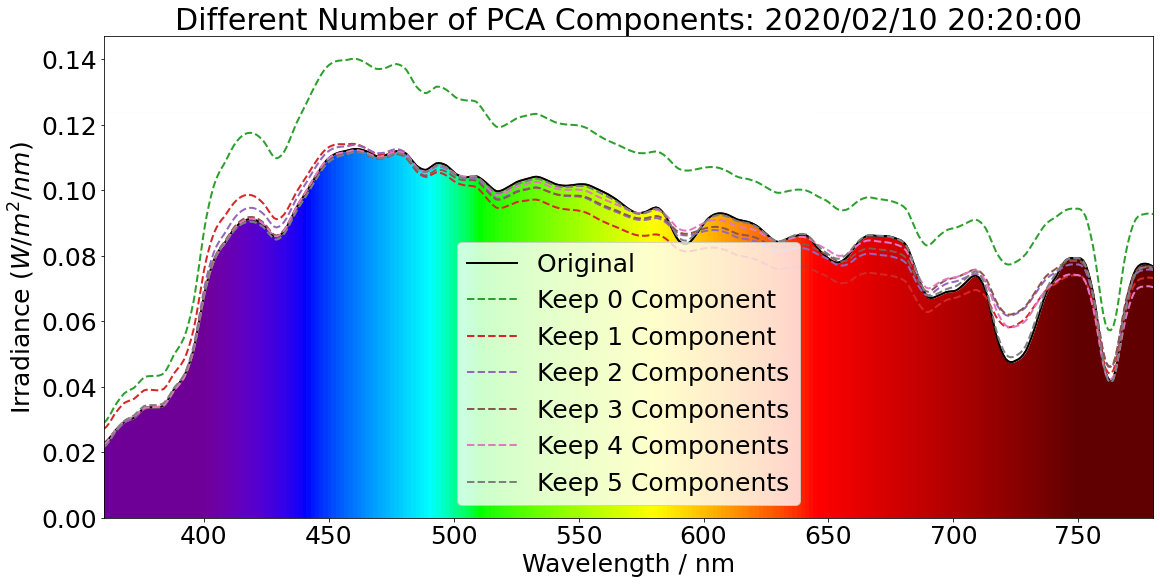

In [743]:
# PCA test

year1 = 2020
month1 = 2
day1 = 10
hour1 = 20
minute1 = 20
second1 = 0
lag = 6
date_string1 = '%04d-%02d-%02d %02d:%02d:%02d' % (year1, month1, day1, hour1, minute1, second1)
print(date_string1)

wavelengths = np.array(range(360,780+1))

iwant = (X_train_DR.index == date_string1)
Y1 = Y_train[iwant].values
Y1_train_distance2_scaled = Y_train_distance2_scaled[iwant]
# Y1 = pca_y.inverse_transform(pca_y.transform(Y1))



# Y1_pred = scaler_y.inverse_transform(pca_y.inverse_transform(pca_y.transform(scaler_y.transform(Y1))))


# actual
date_string = date_string1
spectrum = Y1[0]
Y_max = Y1[0].max()

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')

plt.plot(wavelengths, Y1[0], '-', color = 'black', linewidth = 2, label = 'Original ')

for num_pca_keep in range(5+1):
    Y1_trans = np.matmul(Y1_train_distance2_scaled, pca_y.components_[:num_pca_keep].T)
    Y1_inverse = np.matmul(Y1_trans, pca_y.components_[:num_pca_keep])

    Y1_pca = scaler_y.inverse_transform(Y1_inverse)
    for i, target in enumerate(targets):
        Y1_pca[:,i] /= df['Sun Distance'][X1.index]**2

    plt.plot(wavelengths, Y1_pca[0], '--', linewidth = 2, label = 'Keep '+str(num_pca_keep)+' Component' + 's'*(num_pca_keep>1))


ax.set_title('Different Number of PCA Components: '+ date_string.replace('-','/'))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')
plt.legend()
fig.savefig(dir_out+ 'whole' + '/Spectrum_Street_PCA_test_' + date_string.replace('-','_').replace(' ','_').replace(':','_')+'.png')
# plt.close()
